In [1]:
import sys
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, cross_val_score

from sklearn.pipeline import make_pipeline

from sklearn import metrics

import mlflow
local_tracking_uri = os.path.abspath('../' + 'mlruns')
mlflow.set_tracking_uri(local_tracking_uri)

mlflow_client = mlflow.tracking.MlflowClient()

# Custom modules

import sys
import os
ROOT_DIR = os.path.abspath('../')
sys.path.insert(0, ROOT_DIR + "/src")

import utils

# Approach

- Based on EDA results from notebook `01_eda`, the baseline we're going to use is 55% accuracy by predicting all customers being female.
- Given this dataset and a timeline of a few days, a reasonable goal is to build a classifier with 70% accuracy.

# Constants

In [4]:
TRAIN_INPUT_PATH = '../data/process/train_data_fe3.csv'
TEST_INPUT_PATH = '../data/process/test_data_fe3.csv'
LABEL_COL = 'gender'

SCORING = ['roc_auc', 'f1_micro', 'f1_weighted', 'precision', 'recall']

# Load input

In [5]:
train_df = pd.read_csv(TRAIN_INPUT_PATH)
test_df = pd.read_csv(TEST_INPUT_PATH)

In [6]:
train_df

,age = 2,age = 3,age = 4,age = 5,age = 1,age = 6,age = 0,age is unknown,SUM(txn_logs.step),SUM(txn_logs.amount),...,MODE(txn_logs.merchant) is unknown,NUM_UNIQUE(txn_logs.merchants.category),MODE(txn_logs.merchants.category) = es_transportation,MODE(txn_logs.merchants.category) = es_health,MODE(txn_logs.merchants.category) = es_wellnessandbeauty,MODE(txn_logs.merchants.category) = es_sportsandtoys,MODE(txn_logs.merchants.category) = es_fashion,MODE(txn_logs.merchants.category) = es_home,MODE(txn_logs.merchants.category) is unknown,gender
0,0,0,1,0,0,0,0,0,14681,4716.20,...,0,5,1,0,0,0,0,0,0,M
1,1,0,0,0,0,0,0,0,15401,5519.77,...,0,10,1,0,0,0,0,0,0,M
2,0,0,1,0,0,0,0,0,2494,2693.84,...,0,6,1,0,0,0,0,0,0,F
3,0,0,0,1,0,0,0,0,14099,4596.03,...,0,8,1,0,0,0,0,0,0,M
4,0,1,0,0,0,0,0,0,15827,5739.56,...,0,6,1,0,0,0,0,0,0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3275,0,1,0,0,0,0,0,0,963,2917.90,...,0,6,0,0,0,1,0,0,0,M
3276,1,0,0,0,0,0,0,0,9566,2854.58,...,0,5,1,0,0,0,0,0,0,F
3277,0,0,0,0,1,0,0,0,10407,2008.11,...,0,5,1,0,0,0,0,0,0,F
3278,0,0,1,0,0,0,0,0,960,390.57,...,0,4,0,0,0,1,0,0,0,F


In [7]:
all_df = pd.concat([train_df, test_df], axis=0)

# Generate X, y

In [8]:
le = LabelEncoder()

In [9]:
X_train, y_train = train_df.drop(columns=[LABEL_COL]), le.fit_transform(train_df[LABEL_COL])
X_test, y_test = test_df.drop(columns=[LABEL_COL]), le.transform(test_df[LABEL_COL])
X_all, y_all = all_df.drop(columns=[LABEL_COL]), le.transform(all_df[LABEL_COL])

# First fit

In [10]:
clf_name = 'LightGBM'

In [11]:
train_data = lgb.Dataset(X_train, y_train, feature_name=X_train.columns.tolist())
validation_data = lgb.Dataset(X_test, y_test, reference=train_data)

In [18]:
param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'auc'

In [19]:
num_round = 100
bst = lgb.train(param, train_data, num_round, 
                valid_sets=[validation_data],
                early_stopping_rounds=20)

[1]	valid_0's auc: 0.527513
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.52254
[3]	valid_0's auc: 0.515981
[4]	valid_0's auc: 0.511082
[5]	valid_0's auc: 0.516178
[6]	valid_0's auc: 0.511819
[7]	valid_0's auc: 0.510364
[8]	valid_0's auc: 0.511685
[9]	valid_0's auc: 0.504425
[10]	valid_0's auc: 0.51181
[11]	valid_0's auc: 0.508685
[12]	valid_0's auc: 0.508778
[13]	valid_0's auc: 0.500382
[14]	valid_0's auc: 0.497552
[15]	valid_0's auc: 0.500179
[16]	valid_0's auc: 0.496583
[17]	valid_0's auc: 0.495602
[18]	valid_0's auc: 0.492281
[19]	valid_0's auc: 0.496711
[20]	valid_0's auc: 0.498828
[21]	valid_0's auc: 0.501702
Early stopping, best iteration is:
[1]	valid_0's auc: 0.527513


# Evaluate

## Cross Validation

In [20]:
full_train_data = lgb.Dataset(X_all, y_all, feature_name=X_all.columns.tolist())

In [21]:
eval_hist = lgb.cv(param, full_train_data, bst.best_iteration, nfold=5)

In [22]:
eval_hist

{'auc-mean': [0.4997642871886788], 'auc-stdv': [0.012234340811025346]}

In [23]:
train_score_agg_dict = {'test_roc_auc': np.mean(eval_hist['auc-mean'])}

In [24]:
train_score_agg_dict

{'test_roc_auc': 0.4997642871886788}

### Store run info in MLflow

In [25]:
experiment = mlflow.set_experiment("8-featuretools")

INFO: '8-featuretools' does not exist. Creating a new experiment


In [26]:
with mlflow.start_run(experiment_id=experiment):
    mlflow.log_param('data', 'fe3')
    mlflow.log_param('num_tf', None)
    mlflow.log_param('clf', clf_name)
    mlflow.log_params(param)
    mlflow.log_metrics({**train_score_agg_dict})
    mlflow.set_tag("issue", "8")

# Archive

# Hyperparm tuning

In [60]:
random_state = 42
num_folds = 3

In [17]:
kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

In [57]:
cnt_features = X_all.shape[1]

## Hyperopt

Reference: https://www.kaggle.com/ilialar/hyperparameters-tunning-with-hyperopt

In [12]:
from hyperopt import fmin, tpe, hp, anneal, Trials

In [58]:
def rf_f1_cv(params, random_state=random_state, cv=kf, X=X_all, y=y_all):
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']),
              'min_samples_split': int(params['min_samples_split']),
              'min_samples_leaf': int(params['min_samples_leaf']),
              'max_features': int(params['max_features']),
              'bootstrap': bool(params['bootstrap'])
             }
    
    model = RandomForestClassifier(random_state=random_state, **params)
    
    score = -cross_val_score(model, X, y, cv=cv, scoring="f1_micro", n_jobs=-1).mean()

    return score

In [62]:
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'min_samples_split': hp.quniform('min_samples_split', 3, 50, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 50, 1),
       'max_features': hp.quniform('max_features', 3, cnt_features, 1),
       'bootstrap': hp.choice('bootstrap', (True, False))
      }
# n_iter = 2
timeout = 900

trials = Trials()

best=fmin(fn=rf_f1_cv, # function to optimize
          space=space,
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
#           max_evals=n_iter, # maximum number of iterations
          timeout=timeout,
          trials=trials, # logging
          rstate=np.random.RandomState(random_state), # fixing random state for the reproducibility
         )

  0%|          | 85/9223372036854775807 [15:04<27257659511562695:06:40, 10.64s/trial, best loss: -0.5502468240614099]


In [76]:
best

{'bootstrap': 0,
 'max_depth': 2.0,
 'max_features': 13.0,
 'min_samples_leaf': 37.0,
 'min_samples_split': 30.0,
 'n_estimators': 136.0}

In [79]:
best=fmin(fn=rf_f1_cv, # function to optimize
          space=space,
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
#           max_evals=n_iter, # maximum number of iterations
          timeout=900,
          trials=trials, # logging
          rstate=np.random.RandomState(random_state), # fixing random state for the reproducibility
         )

  0%|          | 152/9223372036854775807 [15:03<15234626903791172:16:00,  5.95s/trial, best loss: -0.5502471810789283] 


#### Visualize

In [ ]:
tpe_results = np.array([[x['result']['loss'],
                         x['misc']['vals']['min_samples_split'][0],
                         x['misc']['vals']['min_samples_leaf'][0],
                         x['misc']['vals']['max_depth'][0],
                         x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df = pd.DataFrame(tpe_results,
                              columns=['score', 'min_samples_split',
                                     'min_samples_leaf', 'max_depth',
                                     'n_estimators'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fabde6a4d00>,
      dtype=object)

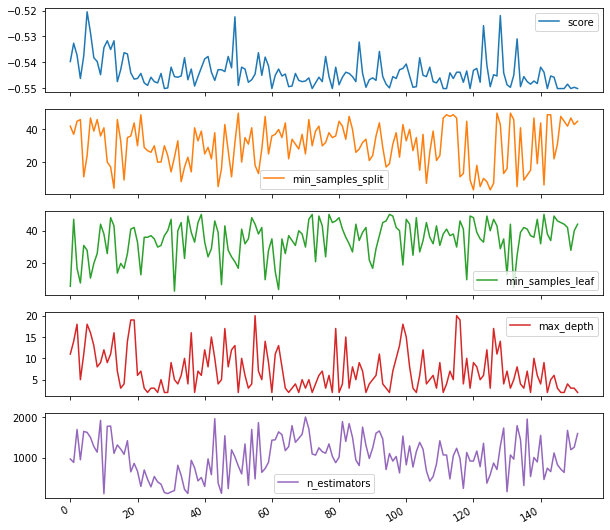

In [89]:
tpe_results_df.plot(subplots=True,figsize=(10, 10))

#### Persist trials

In [80]:
TRIAL_PERSIST_DIR = '../data/process/'

In [81]:
import pickle

filename = f"{TRIAL_PERSIST_DIR}/11-trials-rf.pkl"

# The trials database now contains 100 entries, it can be saved/reloaded with pickle or another method
pickle.dump(trials, open(filename, "wb"))
trials = pickle.load(open(filename, "rb"))

# Fit

In [90]:
clf_name = "RandomForest"

In [96]:
best

{'bootstrap': 0,
 'max_depth': 4.0,
 'max_features': 6.0,
 'min_samples_leaf': 41.0,
 'min_samples_split': 49.0,
 'n_estimators': 1062.0}

In [100]:
clf_params = {}
for k, v in best.items():
    if k in ('bootstrap'):
        v = bool(v)
    else:
        v = int(v)
    clf_params[k] = v

In [101]:
clf = RandomForestClassifier(**clf_params)

In [102]:
pipeline = make_pipeline(clf)

## Holdout

In [ ]:
holdout_score_agg_dict = dict()
for scorer_name in SCORING:
    scorer = metrics.get_scorer(scorer_name)
    score = scorer(pipeline, X_test, y_test)
    holdout_score_agg_dict[f"holdout_{scorer_name}"] = score    

In [ ]:
holdout_score_agg_dict

# Feature importance

In [108]:
fi_df = pd.DataFrame({'fi': clf.feature_importances_}, index=X_train.columns)
fi_df.sort_values(['fi'], ascending=False).head(20) \
    .style.bar()

,fi
category_es_health,0.064910
amount_min,0.050616
merchant_nunique,0.044829
fraud_sum,0.038862
amount_median,0.038598
amount_std,0.037752
amount_mean,0.036004
amount_max,0.034455
step_mean,0.033999
step_median,0.033960


# Learning curve

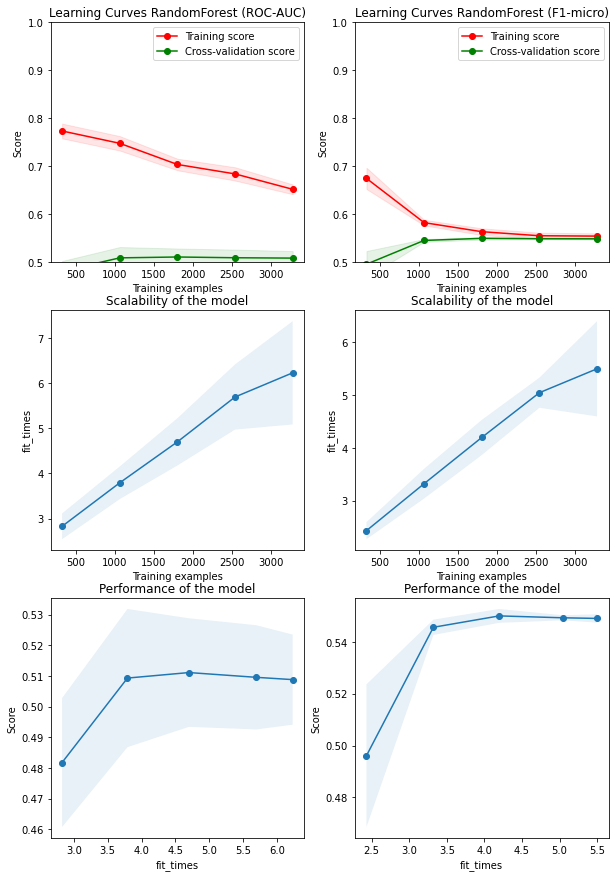

In [109]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
cv = 5
title = f"Learning Curves {clf_name} (ROC-AUC)"
train_sizes, train_scores, test_scores = \
    utils.plot_learning_curve(clf, title, X_all, y_all, axes=axes[:, 0], ylim=(0.7, 1.01),
                              cv=cv, n_jobs=8, scoring='roc_auc')

title = f"Learning Curves {clf_name} (F1-micro)"
train_sizes, train_scores, test_scores = \
    utils.plot_learning_curve(clf, title, X_all, y_all, axes=axes[:, 1], ylim=(0.7, 1.01),
                              cv=cv, n_jobs=8, scoring='f1_micro')

plt.show()

Learning Curve shows that the model is highly underfit, focus should be on feature engineering instead of adding new observations.

# SelectFromModel

In [110]:
clf = pipeline.named_steps['randomforestclassifier']

fs = SelectFromModel(clf, prefit=True)

X_fs = fs.transform(X_all)

X_fs.shape

(4100, 30)

In [111]:
fs_score = cross_validate(pipeline, X_fs, y_all, scoring=SCORING,
                          cv=5, return_train_score=True)

fs_score_df = pd.DataFrame(fs_score)
display(fs_score_df)

fs_score_agg_dict = fs_score_df.mean(axis=0).to_dict()

fs_score_agg_dict

,fit_time,score_time,test_roc_auc,train_roc_auc,test_f1_micro,train_f1_micro,test_f1_weighted,train_f1_weighted,test_precision,train_precision,test_recall,train_recall
0,3.595159,0.218142,0.503422,0.645671,0.552439,0.574085,0.438912,0.462486,0.520833,0.724138,0.067751,0.085424
1,3.663644,0.240230,0.542781,0.659033,0.551220,0.567073,0.424570,0.437124,0.515152,0.783505,0.046070,0.051525
2,3.824491,0.230345,0.499570,0.643025,0.542683,0.578963,0.437873,0.479226,0.451613,0.704348,0.075881,0.109831
3,4.117708,0.228578,0.504011,0.641555,0.551220,0.550915,0.393062,0.392050,1.000000,1.000000,0.002710,0.001356
4,3.887132,0.223648,0.520032,0.658224,0.552439,0.556098,0.394488,0.404939,1.000000,0.916667,0.002717,0.014905


{'fit_time': 3.8176269054412844,
 'score_time': 0.22818856239318847,
 'test_roc_auc': 0.5139631443941703,
 'train_roc_auc': 0.6495014747557484,
 'test_f1_micro': 0.55,
 'train_f1_micro': 0.5654268292682927,
 'test_f1_weighted': 0.4177810795734784,
 'train_f1_weighted': 0.4351651277640082,
 'test_precision': 0.697519550342131,
 'train_precision': 0.8257315156854563,
 'test_recall': 0.039025863084717796,
 'train_recall': 0.0526081484543659}

In [112]:
with mlflow.start_run(experiment_id=experiment):
    mlflow.log_param('data', 'fe21')
    mlflow.log_param('num_tf', None)
    mlflow.log_param('clf', clf_name)
    mlflow.log_param('cnt_features', X_fs.shape[1])
    mlflow.log_params(clf_params)
    mlflow.log_metrics(fs_score_agg_dict)
    mlflow.set_tag("issue", "11")

Reducing from 86 features to 24 features does not affect model's performance. In production, this will be a huge advantages because of less complexity, less time required to produce and maintain the features.

# Archive

In [52]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

# MLflow

In [167]:
mlflow.search_runs()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.holdout_precision,metrics.train_precision,metrics.holdout_f1_weighted,metrics.score_time,...,params.clf,params.data,params.max_iter,params.num_tf,params.cv,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.note.content,tags.eval_set
0,cfe84ff3ee5341cc889f79ba61d8acda,0,FINISHED,/home/quydv1/frostmourne/lich/banksim/mlruns/0...,2020-07-14 17:34:04.895000+00:00,2020-07-14 17:34:05.056000+00:00,0.479592,0.556411,0.500156,0.021375,...,LogisticRegression,fe2,2000,PowerTransformer,None,/home/quydv1/anaconda3/envs/banksim/lib/python...,LOCAL,quydv1,None,None
1,a1448fafcd924ea385ed2b33e2717a04,0,FINISHED,/home/quydv1/frostmourne/lich/banksim/mlruns/0...,2020-07-14 17:28:26.927000+00:00,2020-07-14 17:28:27.089000+00:00,0.460432,0.544958,0.471899,0.009517,...,LogisticRegression,fe2,2000,StandardScaler,None,/home/quydv1/anaconda3/envs/banksim/lib/python...,LOCAL,quydv1,None,None
2,41b94130e16048d88fa703a44f39ff8f,0,FINISHED,/home/quydv1/frostmourne/lich/banksim/mlruns/0...,2020-07-14 16:26:50.776000+00:00,2020-07-14 16:26:50.840000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,/home/quydv1/anaconda3/envs/banksim/lib/python...,LOCAL,quydv1,None,None
3,2b054f5f9ec7457fbbdcc66fb1212b7e,0,FINISHED,/home/quydv1/frostmourne/lich/banksim/mlruns/0...,2020-07-14 16:06:36.456000+00:00,2020-07-14 16:06:36.604000+00:00,NaN,0.200000,NaN,0.012698,...,LogisticRegressionCV,fe1,1000,PowerTransformer,5,/home/quydv1/anaconda3/envs/banksim/lib/python...,LOCAL,quydv1,Ignore results due to a bug at https://github....,train


In [168]:
run_obj = mlflow_client.get_run('cfe84ff3ee5341cc889f79ba61d8acda')

In [169]:
mlflow_client.set_tag(run_obj.info.run_id, "issue", "9")

In [ ]:
run_obj.data